Laden der lightkurve Bibliothek sowie der Bibliotheken astropy, numpy und matplotlib für die weitere Arbeit. %matplotlib inline sichert die korrekte Darstellung der Graphiken im Jupyter Notebook.

In [1]:
import lightkurve as lk
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Der Befehl search_tess_cut prüft in welchen Sektoren die FFI das gewünschte Objekt enthalten

In [2]:
search_result = lk.search_tesscut('V0463 Cyg')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,V0463 Cyg,0.0
1,TESS Sector 41,2021,TESScut,475,V0463 Cyg,0.0
2,TESS Sector 40,2021,TESScut,475,V0463 Cyg,0.0
3,TESS Sector 54,2022,TESScut,475,V0463 Cyg,0.0
4,TESS Sector 55,2022,TESScut,475,V0463 Cyg,0.0


Wir entscheiden uns hier für Sektor 41, also die postion 1 der Liste,  und können dann über den download Befehl einen TargetPixelfile der Größe cutoutsize erzeugen

In [3]:
tpf = search_result[1].download(cutout_size=20)

Plotten wir das mit Einblendung er pipeline_mask für die Photometrie, fällt auf , dass die pipeline_mask leer ist. Da wir den TPF über tesscut erzeugt habn, fehlen die in den pipelines implementierten Verarbeitungsschritte, so auch die ERstellung einer Maske für die Photometrie.

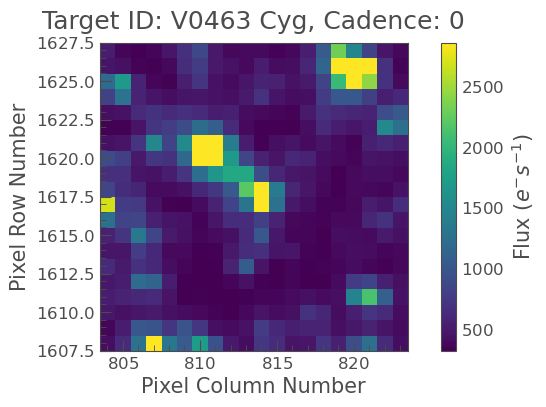

In [4]:
tpf[0].plot(aperture_mask=tpf.pipeline_mask,mask_color='k');

Ein Weg, ist eine "Threshold mask" zuverwenden. Die erfaßt alle zusammenhängenden Pixel um ein festgelegtes Referenzpixel, deren Helligkeit über einen gewissen Grenzwert liegt. Der kann über den Parameter Threshold beeinflußt werden. Wegen des nur wenige Pixel entfernten hellen Nachbarstern funktiniert dass aber für alle WErte von threshold hier nicht wirklich gut, z.B

In [5]:
target_mask = tpf.create_threshold_mask(threshold=7, reference_pixel='center')

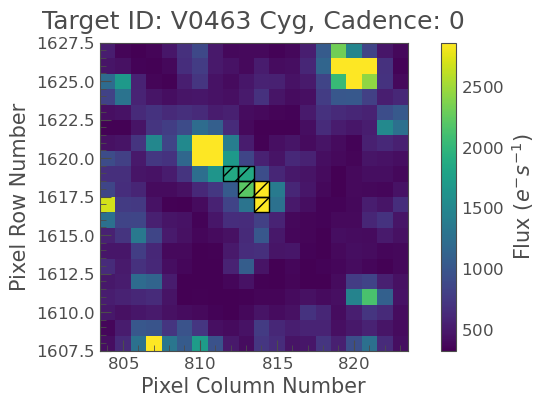

In [6]:
tpf.plot(aperture_mask=target_mask, mask_color='k');

Wir müssen die Maske als manuell bearbeiten, z.B. zu einem 3x3 Fesnter um das Target V0643 Cyg

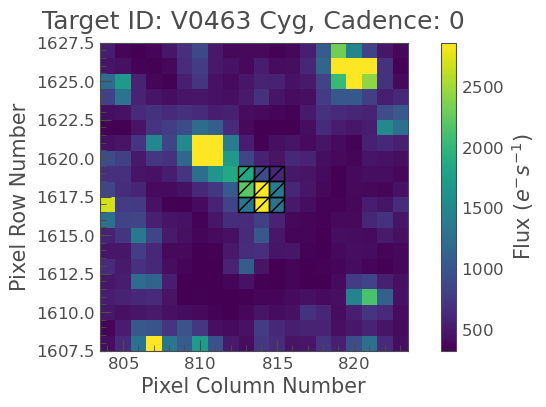

In [14]:
target_mask[:,:]=False
target_mask[9:12,9:12]=True
tpf.plot(aperture_mask=target_mask, mask_color='k');

Damit können wir nun eine erste Lichtkurve erzeugen

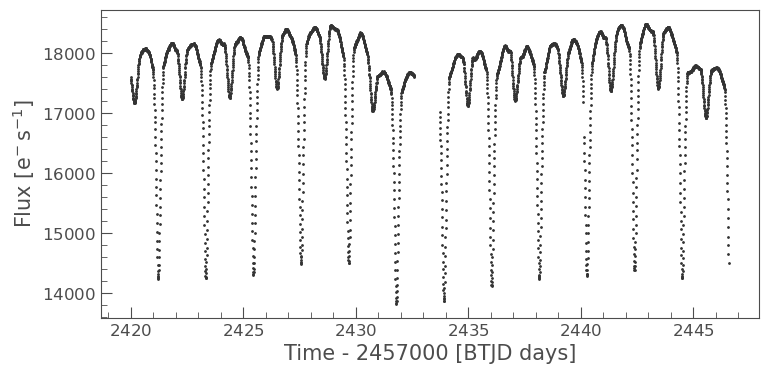

In [8]:
lc=tpf.to_lightcurve(aperture_mask=target_mask)
lc.scatter();

Die sieht deutlich anders aus, als für einen Bedeckungsveränderlichen erwartet. Hier trifft uns ein systematischer Fehler in den TESS FFI DAten, nämlich das mit der Position von Erde und reltiv zu Tess variierende Streulicht, das in den 27 Tage umfassenden Sektoren eine 27/2 Periodizität aufweist. In den von den Pipelines erzeugten Lichtkurven ist das herausgerechnet, hier müssen wir uns darum kümmern.

Lightkurve bietet Werkzeuge, solche Korrekturen vornehmen. Der einfachste Weg ist, die Funktion estimate_bachground zu verwenden. estimate_background sucht über einen Grenzwertbezogen auf den Median der Helligverteilung im TPF alle Pixel, die nicht einem Stern zuzuordnen sind und leitet daraus eine Lichtkurve für die Hintergrund helligkeit ab. 

In [9]:
lcb=tpf.estimate_background()

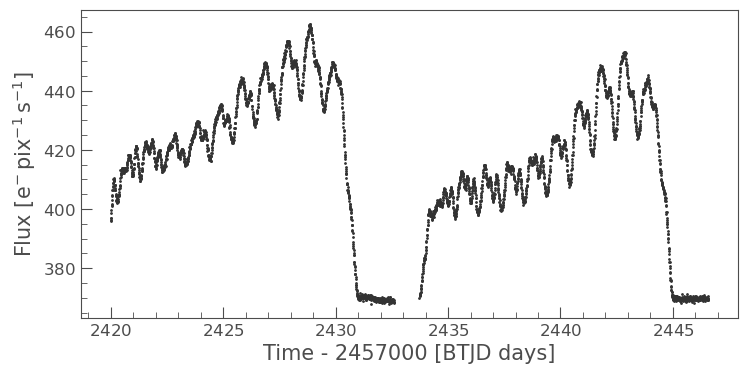

In [11]:
lcb.scatter();

Diese Hintergrundhelligkeit kann dann von der Rohlichtkurve abgezogen werden. Dabei ist beachten, die flux Werte in den Lichtkurven Einheiten tragen. Die Lichtkurve des Sterns wird in Elektronen/s, die des Hintergrunds in Elektronen/pixel/s angegeben. Deswegen die entsprechenden Faktoren unten

In [12]:
n_target_pixels = target_mask.sum()
n_target_pixels
lcc=lc - lcb.flux*ap.units.pix*n_target_pixels

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

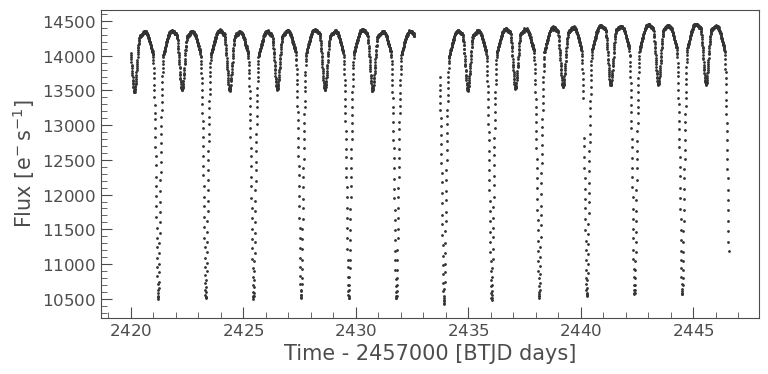

In [13]:
lcc.scatter();

Das einfache Verfahren führt hier offenbar schon zu gutem Ergebnis. Bei Bedarf für komplexere Korekturmöglichkeiten sei auf die Onlinedokumentation verwiesen.